In [11]:
# Imports
import json
import pandas
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import pandas as pd

INGV Data fetch

In [12]:
DELTA_MINUTES = 10
ELEVATION_MIN = 20

In [13]:
# GeoPandas initialization
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [14]:
# INGV Stations lists with related metadata
ingv_stations_list = json.loads(requests.get("http://ws-eswua.rm.ingv.it/scintillation.php/records/wsstation?order=code").content)["records"]
ingv_active_stations_list = list()

for station in ingv_stations_list:
    if station["active_until"] == '': # if no end date of activity specified
        ingv_active_stations_list.append(station)

In [15]:
ingv_base_url = "http://ws-eswua.rm.ingv.it/scintillation.php/records/ws"

# ex d'url : http://ws-eswua.rm.ingv.it/scintillation.php/records/wsthu0p?size=100&order=dt,desc&include=dt,azimuth
def get_s4_raw_lasts(id_station, start_dt, end_dt):

    request_url = ingv_base_url + id_station \
                  + "?filter=dt,bt," + start_dt + "," + end_dt \
                  + "&filter=elevation,gt," + str(ELEVATION_MIN) \
                  + "&order=dt,desc&include=dt,elevation,ipp_lat,ipp_lon,s4_l1_vert"
    response = requests.get(request_url)

    if response.status_code !=200:
        print("ERROR - HTTP Response Code :" + str(response.status_code))
        return -1
    else:
        station_data_records = json.loads(response.content)["records"]
        return station_data_records



current_timedate_str = datetime.now(timezone.utc).isoformat(sep=' ', timespec='seconds')
window_start_timedate_str = (datetime.now(timezone.utc) - timedelta(minutes=DELTA_MINUTES)).isoformat(sep=' ', timespec='seconds')

s4_raw_data = list()
for station in ingv_active_stations_list:
    s4_raw_data += get_s4_raw_lasts(station["code"], window_start_timedate_str, current_timedate_str)
df = pd.DataFrame(s4_raw_data)

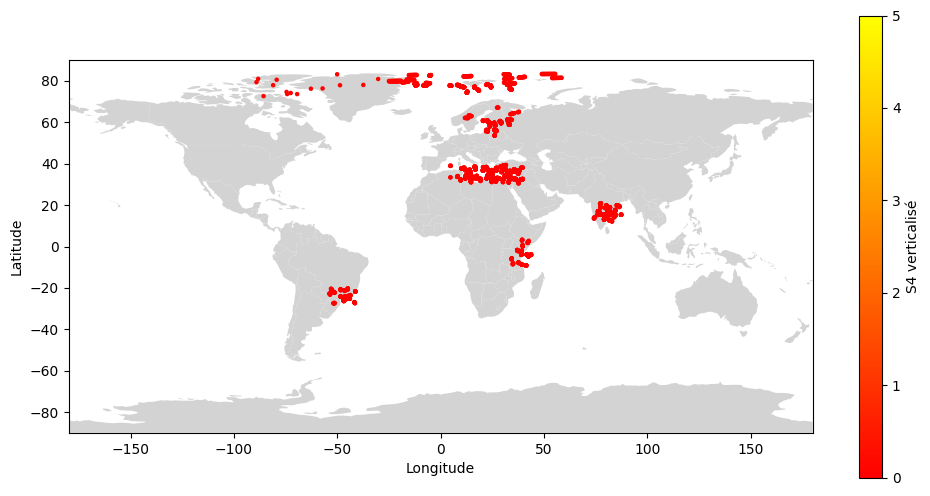

In [36]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)
# Plotting our Impact Energy data with a color map
x = df['ipp_lon']
y = df['ipp_lat']
z = df['s4_l1_vert']
plt.scatter(x, y, s=5, c=z, alpha=1, vmin=0, vmax=5,
            cmap='autumn')
plt.colorbar(label='S4 verticalisé')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

#first_year = df["Datetime"].min().strftime("%Y")
#last_year = df["Datetime"].max().strftime("%Y")
#plt.title("NASA: Fireballs Reported by Government Sensors\n" +
 #         str(first_year) + " - " + str(last_year))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()